In [1]:
import os
os.chdir("/home/ohada/ProjectBDir")

import diffusers
from diffusers import *
import torch
from glob import glob
from diffusers.utils import load_image
from PIL import Image
import unclip
import matplotlib.pyplot as plt
%matplotlib inline

2024-03-31 17:55:43.007570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 17:55:43.665937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ohada/DeepProject/DeepProject/ProjectPath/venv/lib/python3.10/site-packages/diffusers/models/dual_transformer_2d.py:20: FutureWarning: `DualTransformer2DModel` is deprecated and will be removed in version 0.29. Importing `DualTransformer2DModel` from `diffusers.models.dual_transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.transformers.dual_transformer_2d import DualTransformer2DModel`, instead.
  deprecate("DualTransformer2DModel", "0.29", deprecation_message)


In [2]:
import sys
sys.executable

'/home/ohada/DeepProject/DeepProject/ProjectPath/venv/bin/python3'

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

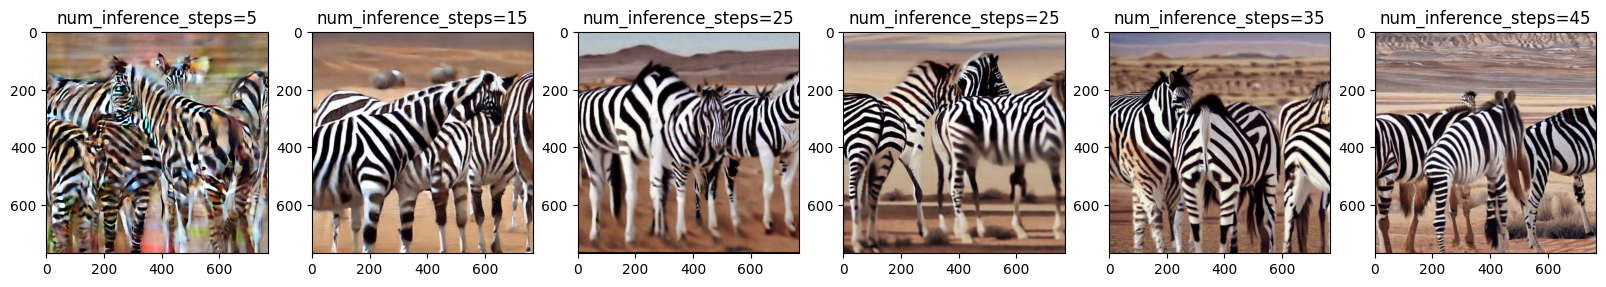

In [19]:
# sweep over "noise_level" and plot the resultes images as subplots:
num_inference_steps = [5, 15, 25, 25, 35, 45]
fig, axs = plt.subplots(1, len(num_inference_steps), figsize=(20, 20))
for i, num_inference_step in enumerate(num_inference_steps):
    img = unclip.unclip(num_inference_steps=num_inference_step, guidance_scale=10, noise_level=0)
    axs[i].imshow(img)
    axs[i].set_title(f"num_inference_steps={num_inference_step}")

In [2]:
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
    ).to("cuda")

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [3]:
horse_images = [load_image(path) for path in sorted(glob("horse2zebra/horse*.jpg"))]
zebra_images = [load_image(path) for path in sorted(glob("horse2zebra/zebra*.jpg"))]
images = horse_images + zebra_images

In [4]:
image_embeds = [pipe._encode_image(
                image=(im,),
                device=pipe.device,
                batch_size=len(images),
                num_images_per_prompt=1,
                do_classifier_free_guidance=False,
                noise_level=torch.zeros((1,), device="cuda", dtype=torch.int),
                generator=None,
                image_embeds=None,
            ) for im in images]
horse_embeds, zebra_embeds = torch.cat(image_embeds).chunk(2, dim=0)
diff = (zebra_embeds[1:] - horse_embeds[1:]).mean(0)

In [14]:
enc = unclip.encode_img(pipe, horse_images[0], 0.05)

OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 105.25 MiB is free. Process 4925 has 237.38 MiB memory in use. Process 822823 has 7.21 GiB memory in use. Including non-PyTorch memory, this process has 16.12 GiB memory in use. Of the allocated memory 15.38 GiB is allocated by PyTorch, and 498.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
images_zebras = pipe(image_embeds=(horse_embeds[0]+diff)[None, :1024],
                     latents=enc).images

  0%|          | 0/21 [00:00<?, ?it/s]

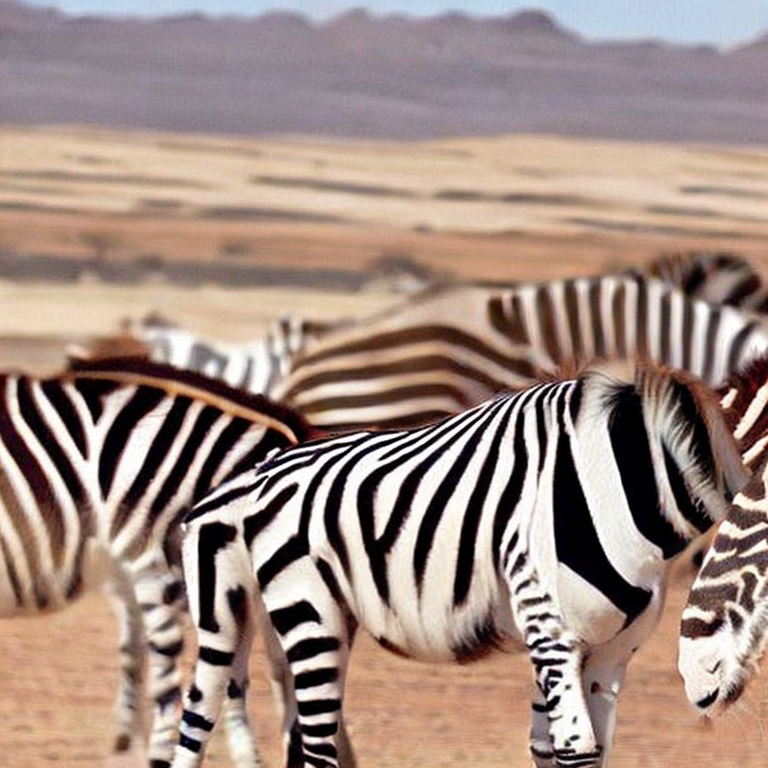

In [16]:
images_zebras[0]